<a href="https://colab.research.google.com/github/flavioluizseixas/IA-Materno-Infantil/blob/main/AvaliandoModeloDeepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("reubensuju/celeb-df-v2")

print("Path to dataset files:", path)

100%|██████████| 9.29G/9.29G [01:04<00:00, 154MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1


In [2]:
!rm -r /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1/Celeb-real/id0_*
!rm -r /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1/Celeb-real/id1_*
!rm -r /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1/Celeb-real/id2_*
!rm -r /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1/Celeb-real/id3_*
!rm -r /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1/Celeb-synthesis/id0_id1_*
!rm -r /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1/Celeb-synthesis/id0_id2_*
!rm -r /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1/Celeb-synthesis/id0_id3_*
!rm -r /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1/Celeb-synthesis/id0_id4_*
!rm -r /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1/Celeb-synthesis/id0_id6_*

In [4]:
!pip install facenet_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16

In [1]:
import cv2
import torch
import os
import shutil
from facenet_pytorch import MTCNN
from torchvision import transforms
from PIL import Image

# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inicializar o detector de faces MTCNN
mtcnn = MTCNN(keep_all=True, device=device)

In [2]:
# Diretórios de entrada e saída
input_dirs = {
    "Deepfake": "/root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1/Celeb-synthesis",
    "Real": "/root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1/Celeb-real"
}
output_base = "videos-teste/CELEB-DF/faces"

In [3]:
# Criar diretórios de saída
for category in ["Deepfake", "Real"]:
    output_dir = os.path.join(output_base, category)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)  # Remove se já existir
    os.makedirs(output_dir, exist_ok=True)

In [4]:
# Função para extrair frames do vídeo
def extract_frames(video_path, interval=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            frames.append((frame, frame_count))
        frame_count += 1

    cap.release()
    return frames

In [5]:
# Função para detectar e salvar faces
def detect_and_save_faces(frames, video_name, category):
    output_dir = os.path.join(output_base, category, video_name)
    os.makedirs(output_dir, exist_ok=True)

    extracted_faces = 0

    for i, (frame, frame_number) in enumerate(frames):
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        boxes, _ = mtcnn.detect(image)

        if boxes is not None:
            for j, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                face = image.crop((x1, y1, x2, y2))

                # Salvar a face extraída
                face_filename = os.path.join(output_dir, f"frame_{frame_number}_face_{j}.jpg")
                face.save(face_filename)
                extracted_faces += 1

    return extracted_faces


In [6]:
LIMIT = 7500

# Contadores de faces extraídas
face_count = {"Real": 0, "Deepfake": 0}

# Processar todos os vídeos nos diretórios
for category, input_dir in input_dirs.items():
    if face_count[category] >= LIMIT:
        print(f"Limite atingido para a categoria {category}, pulando...")
        continue

    for video_file in os.listdir(input_dir):
        video_path = os.path.join(input_dir, video_file)

        if video_file.endswith(('.mp4', '.avi', '.mov', '.mkv')):  # Filtrar tipos de vídeo
            print(f"Processando {video_file} na categoria {category}...")

            frames = extract_frames(video_path, interval=5)
            extracted_faces = detect_and_save_faces(frames, video_file.split('.')[0], category)

            face_count[category] += extracted_faces

            # Parar se atingir o limite
            if face_count[category] >= LIMIT:
                print(f"Limite de {LIMIT} faces atingido para a categoria {category}. Encerrando processamento dessa categoria.")
                break


Processando id31_id20_0003.mp4 na categoria Deepfake...
Processando id30_id34_0000.mp4 na categoria Deepfake...
Processando id16_id9_0009.mp4 na categoria Deepfake...
Processando id2_id28_0007.mp4 na categoria Deepfake...
Processando id38_id37_0002.mp4 na categoria Deepfake...
Processando id37_id29_0006.mp4 na categoria Deepfake...
Processando id43_id48_0005.mp4 na categoria Deepfake...
Processando id53_id56_0000.mp4 na categoria Deepfake...
Processando id7_id13_0004.mp4 na categoria Deepfake...
Processando id17_id1_0001.mp4 na categoria Deepfake...
Processando id53_id51_0002.mp4 na categoria Deepfake...
Processando id3_id6_0001.mp4 na categoria Deepfake...
Processando id17_id28_0003.mp4 na categoria Deepfake...
Processando id61_id5_0000.mp4 na categoria Deepfake...
Processando id55_id52_0001.mp4 na categoria Deepfake...
Processando id16_id0_0006.mp4 na categoria Deepfake...
Processando id17_id3_0009.mp4 na categoria Deepfake...
Processando id31_id16_0000.mp4 na categoria Deepfake...
P

In [10]:
import os
import timm
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# Definir caminho do modelo treinado
MODEL_PATH = "/xception_deepfake.pth"

# Diretórios com as imagens
TEST_DIR = "videos-teste/CELEB-DF/faces"

In [12]:
# Definir transformação das imagens (mesma usada no treinamento)
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Xception usa 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [19]:
# Carregar dataset de teste
test_dataset = ImageFolder(root=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
# Carregar modelo treinado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("xception41.tf_in1k", pretrained=False, num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

XceptionAligned(
  (stem): Sequential(
    (0): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (1): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
  )
  (blocks): Sequential(
    (0): XceptionModule(
      (shortcut): ConvNormAct(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (stack): Sequential(
     

In [20]:
# Fazer inferência
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

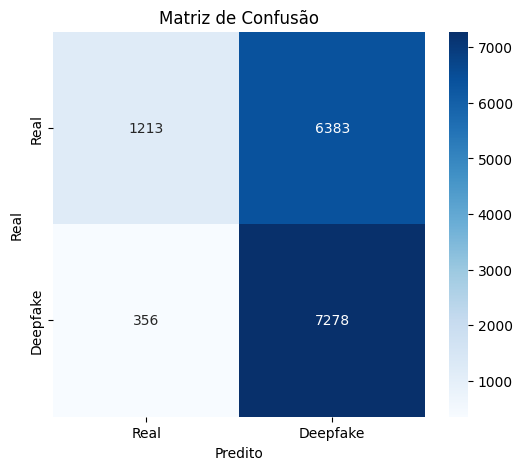

              precision    recall  f1-score   support

        Real       0.77      0.16      0.26      7596
    Deepfake       0.53      0.95      0.68      7634

    accuracy                           0.56     15230
   macro avg       0.65      0.56      0.47     15230
weighted avg       0.65      0.56      0.47     15230



In [21]:
# Criar matriz de confusão
cm = confusion_matrix(all_labels, all_preds)
labels = ["Real", "Deepfake"]

# Exibir matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Exibir relatório de classificação
print(classification_report(all_labels, all_preds, target_names=labels))